# **Data Extraction**

In [6]:
import os
import cv2
import shutil
import numpy as np
import tensorflow as tf
from google.colab import drive
from tensorflow.keras import mixed_precision

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

dataset_root_path = '/content/drive/MyDrive/RESEARCH_PAPER/Raw_Videos'
base_temp_path = '/content/dataset_temp'
final_dataset_path = '/content/dataset_final'

for path in [base_temp_path, final_dataset_path]:
    if os.path.exists(path):
        shutil.rmtree(path)

def extract_frames(subfolder, label, max_frames=80):
    input_dir = os.path.join(dataset_root_path, subfolder)
    output_dir = os.path.join(base_temp_path, label)
    os.makedirs(output_dir, exist_ok=True)

    video_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.mp4', '.mov', '.avi'))]
    print(f"Processing {subfolder}: {len(video_files)} videos found.")

    for v_name in video_files:
        cap = cv2.VideoCapture(os.path.join(input_dir, v_name))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames <= 0:
            cap.release()
            continue

        step = max(1, total_frames // max_frames)
        saved_count = 0
        current_frame = 0

        while saved_count < max_frames:
            success, image = cap.read()
            if not success:
                break

            if current_frame % step == 0:
                img_path = os.path.join(output_dir, f"{v_name}_f{saved_count}.jpg")
                image_resized = cv2.resize(image, (224, 224))
                cv2.imwrite(img_path, image_resized)
                saved_count += 1

            current_frame += 1
        cap.release()

extract_frames('Real', 'real', max_frames=80)
extract_frames('AI', 'ai', max_frames=80)

train_dir = os.path.join(final_dataset_path, 'train')
val_dir = os.path.join(final_dataset_path, 'val')

for cl in ['real', 'ai']:
    os.makedirs(os.path.join(train_dir, cl), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cl), exist_ok=True)

    all_frames = os.listdir(os.path.join(base_temp_path, cl))
    video_names = list(set([f.split('_f')[0] for f in all_frames]))

    np.random.shuffle(video_names)
    split_point = int(0.8 * len(video_names))

    train_vids = video_names[:split_point]

    for f in all_frames:
        v_name = f.split('_f')[0]
        src = os.path.join(base_temp_path, cl, f)
        dest_folder = train_dir if v_name in train_vids else val_dir
        shutil.copy(src, os.path.join(dest_folder, cl, f))

print("Frame extraction and scientific data splitting completed.")

Processing Real: 122 videos found.
Processing AI: 132 videos found.
Frame extraction and scientific data splitting completed.


# **Data Generators and Weights**

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(final_dataset_path, 'train'),
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    os.path.join(final_dataset_path, 'val'),
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

total_training_samples = train_generator.samples
ai_samples = np.sum(train_generator.classes == 0)
real_samples = np.sum(train_generator.classes == 1)

class_weights = {
    0: 1.0,
    1: 1.5
}

Found 18228 images belonging to 2 classes.
Found 2080 images belonging to 2 classes.


# **Model Comparison**

In [9]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def build_transfer_model(base_model_architecture):
    base_model_architecture.trainable = False
    model = models.Sequential([
        base_model_architecture,
        layers.GlobalAveragePooling2D(dtype='float32'),
        layers.BatchNormalization(dtype='float32'),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001), dtype='float32'),
        layers.Dropout(0.7, dtype='float32'),
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

architectures_to_compare = {
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "InceptionV3": InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

all_histories = {}
best_model_performance = {'accuracy': 0, 'name': None, 'model': None, 'history': None}

for model_name, base_architecture in architectures_to_compare.items():
    print(f"Training Model: {model_name}")
    model = build_transfer_model(base_architecture)

    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    checkpoint_path = os.path.join('/content/drive/MyDrive/RESEARCH_PAPER', f'{model_name}_final.weights.h5')
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', save_weights_only=True)

    history = model.fit(
        train_generator,
        epochs=15,
        validation_data=validation_generator,
        class_weight=class_weights,
        callbacks=[early_stopping, model_checkpoint, lr_reducer],
        verbose=1
    )

    all_histories[model_name] = history.history
    val_loss, val_acc = model.evaluate(validation_generator, verbose=0)

    if val_acc > best_model_performance['accuracy']:
        best_model_performance['accuracy'] = val_acc
        best_model_performance['name'] = model_name
        best_model_performance['model'] = model
        best_model_performance['history'] = history.history

final_model = best_model_performance['model']
final_model_name = best_model_performance['name']
final_model.save(f'/content/drive/MyDrive/RESEARCH_PAPER/{final_model_name}_best_research_model.keras')

print(f"Training complete. Best model is: {final_model_name}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Model: ResNet50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 292s 961ms/step - accuracy: 0.5852 - loss: 1.4954 - val_accuracy: 0.5798 - val_loss: 1.0553 - learning_rate: 1.0000e-04
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 260s 910ms/step - accuracy: 0.6369 - loss: 1.1092 - val_accuracy: 0.6519 - val_loss: 0.8889 - learning_rate: 1.0000e-04
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 259s 909ms/step - accuracy: 0.6486 - loss: 1.0131 - val_accuracy: 0.6712 - val_loss: 0.8134 - learning_rate: 1.0000e-04
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 260s 913ms/step - accuracy: 0.6643 - loss: 0.9649 - val_accuracy: 0.6865 - val_loss: 0.7963 - learning_rate: 1.0000e-04
Epoch 5/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 261s 913ms/step - accuracy: 0.6768 - loss: 0.9316 - val_accuracy: 0.6457 - val_loss: 0.8023 - learning_rate: 1.0000e-04
Epoch 6/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 260s 913ms/step - accuracy: 0.6769 - loss: 0.9163 - val_accuracy: 0.6582 - val_loss: 0.7760 - learning_rate: 1.0000e-04
Epoch 7/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 

# **Performance Visualization**

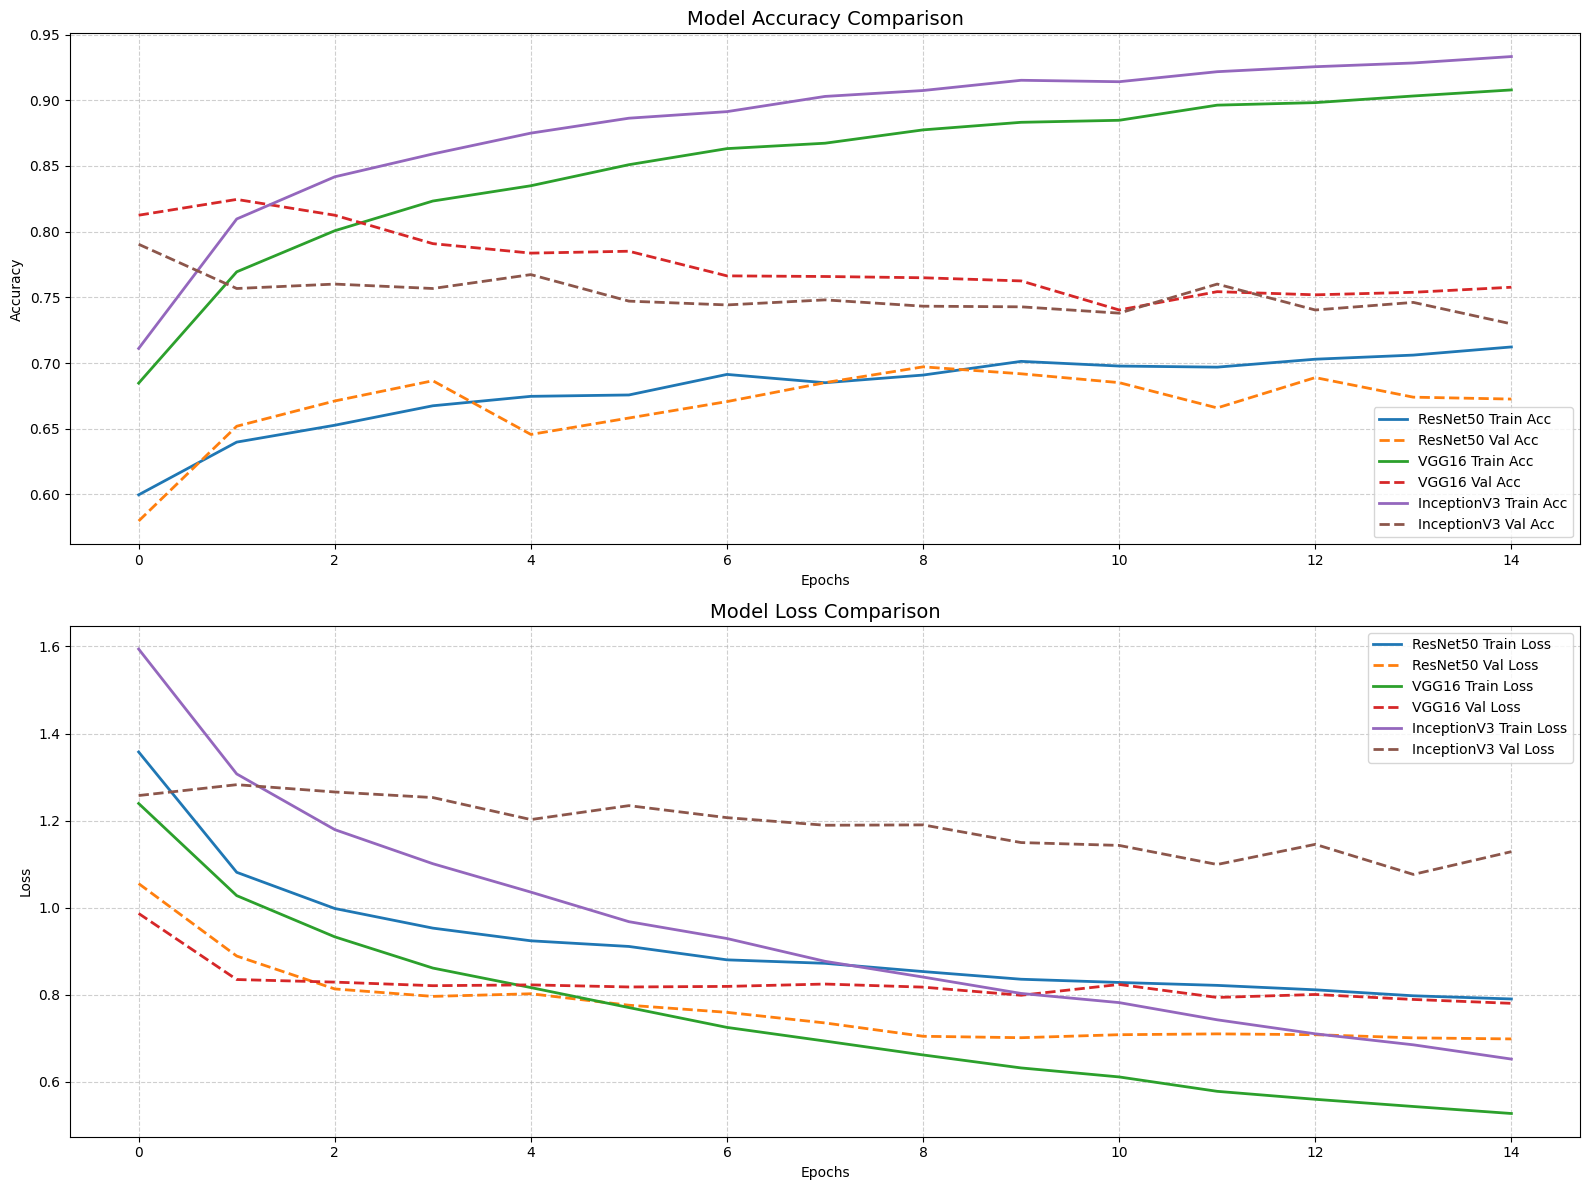

Graph saved at: /content/drive/MyDrive/RESEARCH_PAPER/model_comparison_curves.png


In [12]:
import matplotlib.pyplot as plt
import os

plt.figure(figsize=(16, 12))


plt.subplot(2, 1, 1)
for name, hist in all_histories.items():
    plt.plot(hist['accuracy'], label=f'{name} Train Acc', linewidth=2)
    plt.plot(hist['val_accuracy'], label=f'{name} Val Acc', linestyle='--', linewidth=2)
plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)


plt.subplot(2, 1, 2)
for name, hist in all_histories.items():
    plt.plot(hist['loss'], label=f'{name} Train Loss', linewidth=2)
    plt.plot(hist['val_loss'], label=f'{name} Val Loss', linestyle='--', linewidth=2)
plt.title('Model Loss Comparison', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

save_path = '/content/drive/MyDrive/RESEARCH_PAPER/model_comparison_curves.png'
plt.savefig(save_path)
plt.show()

print(f"Graph saved at: {save_path}")

# **Evaluation Reports**

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step
Final Research Evaluation Report for VGG16:
              precision    recall  f1-score   support

          AI       0.74      0.79      0.76      1040
        Real       0.77      0.73      0.75      1040

    accuracy                           0.76      2080
   macro avg       0.76      0.76      0.76      2080
weighted avg       0.76      0.76      0.76      2080



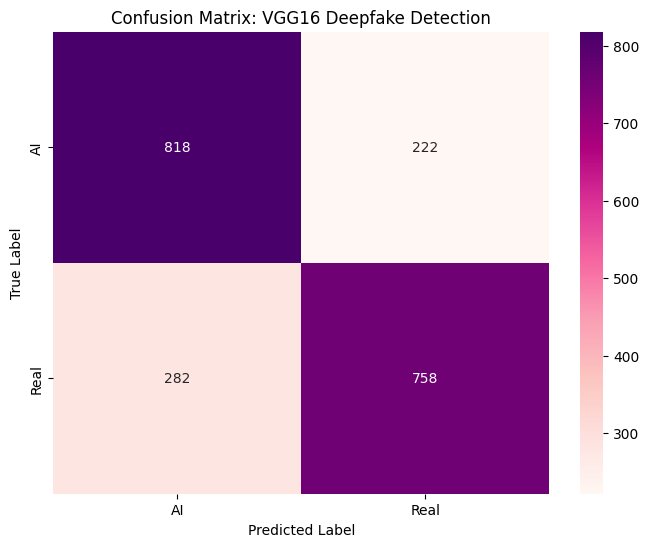

Confusion Matrix saved at: /content/drive/MyDrive/RESEARCH_PAPER/VGG16_confusion_matrix.png


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


validation_generator.reset()
y_pred_probs = final_model.predict(validation_generator)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true = validation_generator.classes


print(f"Final Research Evaluation Report for {final_model_name}:")
report = classification_report(y_true, y_pred_classes, target_names=['AI', 'Real'])
print(report)


cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', xticklabels=['AI', 'Real'], yticklabels=['AI', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix: {final_model_name} Deepfake Detection')


save_path = os.path.join('/content/drive/MyDrive/RESEARCH_PAPER', f'{final_model_name}_confusion_matrix.png')
plt.savefig(save_path)
plt.show()

print(f"Confusion Matrix saved at: {save_path}")

In [17]:
import pandas as pd

comparison_data = []

for name in architectures_to_compare.keys():
    acc = max(all_histories[name]['val_accuracy'])
    loss = min(all_histories[name]['val_loss'])
    comparison_data.append({
        'Model': name,
        'Max Val Accuracy': f"{acc*100:.2f}%",
        'Min Val Loss': f"{loss:.44f}"
    })

df = pd.DataFrame(comparison_data)
print("Comparison Table for Research Paper:")
print(df.to_string(index=False))


df.to_csv('/content/drive/MyDrive/RESEARCH_PAPER/model_comparison_results.csv', index=False)

Comparison Table for Research Paper:
      Model Max Val Accuracy                                   Min Val Loss
   ResNet50           69.71% 0.69860583543777465820312500000000000000000000
      VGG16           82.45% 0.78033828735351562500000000000000000000000000
InceptionV3           79.04% 1.07640850543975830078125000000000000000000000


# **ROC Curve**

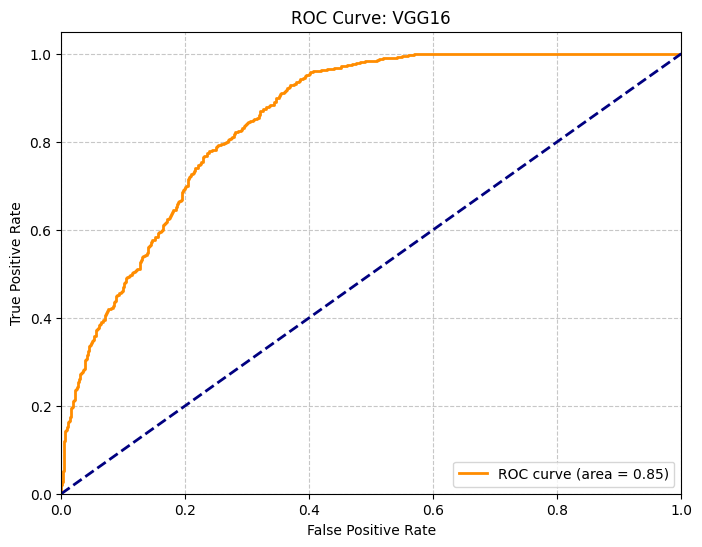

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: {final_model_name}')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(f'/content/drive/MyDrive/RESEARCH_PAPER/{final_model_name}_roc_curve.png')
plt.show()

# **Single Video Testing**

In [19]:
def test_video(video_path, model, frames_to_check=80):
    cap = cv2.VideoCapture(video_path)
    frame_list = []
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total <= 0:
        cap.release()
        return

    interval = max(1, total // frames_to_check)

    for i in range(frames_to_check):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224)) / 255.0
        frame_list.append(frame)
    cap.release()

    if not frame_list:
        return

    res = model.predict(np.array(frame_list), verbose=0)
    avg_score = np.mean(res)

    final_label = "REAL" if avg_score > 0.5 else "AI"
    final_conf = avg_score if avg_score > 0.5 else (1 - avg_score)

    print(f"File: {os.path.basename(video_path)}")
    print(f"Prediction: {final_label}")
    print(f"Confidence: {final_conf * 100:.2f}%")

video_to_test = '/content/drive/MyDrive/RESEARCH_PAPER/test.mp4'
if os.path.exists(video_to_test):
    test_video(video_to_test, final_model)
else:
    print("Video file not found. Please check the path.")

File: test.mp4
Prediction: REAL
Confidence: 93.52%
